In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize
from scipy.special import erf
from matplotlib import cm
import emcee
from getdist import MCSamples, plots


In [2]:
data_oldbao = np.array([
    [0.122, 539.0],
    [0.38, 10.23406],    
    [0.38, 24.98058],                   
    [0.51, 13.36595],   
    [0.51, 22.31656],    
    [0.698, 17.8582369],  
    [0.698, 19.32575373],  
    [0.81, 10.75],
    [1.48, 30.6876],     
    [1.48, 13.2609],     
    [2.334, 37.5],       
    [2.334, 8.99]        
])

z_oldbao = data_oldbao[:,0]
oldbao_val = data_oldbao[:,1]

print("Number of BAO points:", len(z_oldbao))
print("First 5 rows:\n", data_oldbao[:5])

cov_matrix_old=np.array([[289,0,0,0,0,0,0,0,0,0,0,0],
[0,0.0286052,-0.04939281,0.01489688,-0.01387079,0,0,0,0,0,0,0],
[0,-0.04939281,0.5307187,-0.02423513,0.1767087,0,0,0,0,0,0,0],
[0,0.01489688,-0.02423513,0.04147534,-0.04873962,0,0,0,0,0,0,0],
[0,-0.01387079,0.1767087,-0.04873962,0.3268589,0,0,0,0,0,0,0],
[0,0,0,0,0,0.1076634008565565,-0.05831820341302727,0,0,0,0,0],
[0,0,0,0,0,-0.05831820341302727,0.2838176386,0,0,0,0,0],
[0,0,0,0,0,0,0,0.1849,0,0,0,0],
[0,0,0,0,0,0,0,0,0.63731604,0.1706891,0,0],
[0,0,0,0,0,0,0,0,0.1706891,0.30468415,0,0],
[0,0,0,0,0,0,0,0,0,0,1.3225,-0.1009],
[0,0,0,0,0,0,0,0,0,0,-0.1009,0.038]])
print((cov_matrix_old.shape))

# --- data values from Table II (paper) in the exact Table-II order ---
data_newbao = np.array([
    [0.122, 539.0],                    # DV (rs,fid/rs) ±17
    [0.38,  10.23406],                 # DM/rs (correlated block)
    [0.38,  24.98058],                 # DH/rs (correlated block)
    [0.51,  13.36595],                 # DM/rs (correlated block)
    [0.51,  22.31656],                 # DH/rs (correlated block)
    [0.698, 17.85823691865007],        # DM/rs (correlated block)
    [0.698, 19.32575373059217],        # DH/rs (correlated block)
    [0.835, 18.92],                    # DM/rs ±0.51 (uncorrelated)
    [1.48,  30.6876],                  # DM/rs (correlated pair)
    [1.48,  13.2609],                  # DH/rs (correlated pair)
    [2.334, 37.5],                     # DM/rs (correlated pair)
    [2.334, 8.99],                     # DH/rs (correlated pair)
])

z_newbao = data_newbao[:,0].copy()
newbao_val = data_newbao[:,1].copy()

# --- Build 12x12 covariance ---
C = np.zeros((12,12))

# 1) Uncorrelated diagonal entries:
# index 0 -> 539 ± 17 -> variance = 17^2 = 289
C[0,0] = 17.0**2
# index 7 -> 18.92 ± 0.51 -> variance = 0.51^2
C[7,7] = 0.51**2

# 2) Correlated block for Ref.[114] (indices 1..4) -- Eq. (10)
C_114 = np.array([
    [ 0.02860520, -0.04939281,  0.01489688, -0.01387079],
    [-0.04939281,  0.5307187,  -0.02423513,  0.1767087 ],
    [ 0.01489688, -0.02423513,  0.04147534, -0.04873962],
    [-0.01387079,  0.1767087,  -0.04873962,  0.3268589 ]
])
C[1:5, 1:5] = C_114

# 3) Correlated 2x2 for indices 5..6 (Refs.[114],[115]) -- Eq. (11)
C_698 = np.array([
    [ 0.1076634008565565, -0.05831820341302727],
    [-0.05831820341302727, 0.2838176386340292]
])
C[5:7, 5:7] = C_698

# 4) index 8..9 (1.48 pair) correlation matrix Eq. (12)
C_148 = np.array([
    [0.63731604, 0.1706891],
    [0.1706891,  0.30468415]
])
C[8:10, 8:10] = C_148

# 5) index 10..11 (2.334 pair) correlation matrix Eq. (9)
C_2334 = np.array([
    [ 1.3225, -0.1009],
    [-0.1009,  0.0380]
])
C[10:12, 10:12] = C_2334
cov_matrix_new=C
print((cov_matrix_new.shape))
#print(cov_matrix_new-cov_matrix_old)

Number of BAO points: 12
First 5 rows:
 [[1.220000e-01 5.390000e+02]
 [3.800000e-01 1.023406e+01]
 [3.800000e-01 2.498058e+01]
 [5.100000e-01 1.336595e+01]
 [5.100000e-01 2.231656e+01]]
(12, 12)
(12, 12)


In [3]:
data_oldHz = np.array([
    [0.07, 69.0, 19.6],
    [0.09, 69.0, 12.0],
    [0.12, 68.6, 26.2],
    [0.17, 83.0, 8.0],
    [0.179, 75.0, 4.0],
    [0.199, 75.0, 5.0],
    [0.2, 72.9, 29.6],
    [0.27, 77.0, 14.0],
    [0.28, 88.8, 36.6],
    [0.352, 83.0, 14.0],
    [0.3802, 83.0, 13.5],
    [0.4, 95.0, 17.0],
    [0.4004, 77.0, 10.2],
    [0.4247, 87.1, 11.2],
    [0.43, 86.45, 3.68],
    [0.4497, 92.8, 12.9],
    [0.47, 89.0, 34.0],
    [0.4783, 80.9, 9.0],
    [0.48, 97.0, 62.0],
    [0.5929, 104.0, 13.0],
    [0.6797, 92.0, 8.0],
    [0.7812, 105.0, 12.0],
    [0.8754, 125.0, 17.0],
    [0.88, 90.0, 40.0],
    [0.9, 117.0, 23.0],
    [1.037, 154.0, 20.0],
    [1.3, 168.0, 17.0],
    [1.363, 160.0, 33.6],
    [1.43, 177.0, 18.0],
    [1.53, 140.0, 14.0],
    [1.75, 202.0, 40.0],
    [1.965, 186.5, 50.4]
])

z_data_old = data_oldHz[:,0]
Hz_data_old = data_oldHz[:,1]
sigma_data_old = data_oldHz[:,2]


data_newHz = np.array([
    [0.07,   69.0],
    [0.09,   69.0],
    [0.12,   68.6],
    [0.17,   83.0],
    [0.20,   72.9],
    [0.27,   77.0],
    [0.28,   88.8],
    [0.40,   95.0],
    [0.47,   89.0],
    [0.48,   97.0],
    [0.75,   98.8],
    [0.88,   90.0],
    [0.90,  117.0],
    [1.30,  168.0],
    [1.43,  177.0],
    [1.53,  140.0],
    [1.75,  202.0],
    [0.1791,  74.91],
    [0.1993,  74.96],
    [0.3519,  82.78],
    [0.3802,  83.00],
    [0.4004,  76.97],
    [0.4247,  87.08],
    [0.4497,  92.78],
    [0.4783,  80.91],
    [0.5929, 103.80],
    [0.6797,  91.60],
    [0.7812, 104.50],
    [0.8754, 125.10],
    [1.0370, 153.70],
    [1.3630, 160.00],
    [1.9650, 186.50],
])


z_data_new = data_newHz[:,0]
Hz_data_new = data_newHz[:,1]
N_uncorr = 17
N_corr = 15

cov_corr = np.array([[  30.97980293,   16.49812045,   18.21924241,   18.54700391,
          18.2058504 ,   21.96673768,   22.79064919,   19.44644971,
          25.95946765,   21.11754814,   21.51369172,   14.36245692,
          21.268649  ,   15.25338754,   17.78472019],
       [  16.49812045,   40.52045739,   18.23140316,   18.55938343,
          18.21800222,   21.98139977,   22.80586121,   19.45942959,
          25.97679475,   21.13164342,   21.52805141,   14.37204339,
          21.28284513,   15.26356869,   17.79659092],
       [  18.21924241,   18.23140316,  214.69204463,   20.49554109,
          20.11854621,   24.27455007,   25.18502122,   21.48948214,
          28.68675386,   23.33614517,   23.77390736,   15.87136809,
          23.5031206 ,   16.85589936,   19.65317231],
       [  18.54700391,   18.55938343,   20.49554109,  204.19588873,
          20.48063831,   24.71160518,   25.63842786,   21.87640757,
          29.20398504,   23.75608184,   24.20151578,   16.15520296,
          23.92632907,   17.15924205,   20.00677079],
       [  18.2058504 ,   18.21800222,   20.11854621,   20.48063831,
         123.73689379,   24.25833567,   25.16801202,   21.47519381,
          28.67092534,   23.31954845,   23.75606695,   15.85205244,
          23.48761482,   16.84399657,   19.63891108],
       [  21.96673768,   21.98139977,   24.27455007,   24.71160518,
          24.25833567,  155.60875982,   30.36862677,   25.91296637,
          34.59893843,   28.13736218,   28.66312632,   19.11899815,
          28.34136931,   20.32404844,   23.69602004],
       [  22.79064919,   22.80586121,   25.18502122,   25.63842786,
          25.16801202,   30.36862677,  197.91728853,   26.88450751,
          35.89531484,   29.19257554,   29.73829355,   19.83803967,
          29.40392648,   21.08622363,   24.58474526],
       [  19.44644971,   19.45942959,   21.48948214,   21.87640757,
          21.47519381,   25.91296637,   26.88450751,  104.73399039,
          30.62980259,   24.90915579,   25.37451556,   16.92475337,
          25.08986526,   17.99227305,   20.97734455],
       [  25.95946765,   25.97679475,   28.68675386,   29.20398504,
          28.67092534,   34.59893843,   35.89531484,   30.62980259,
         197.09955561,   33.25420157,   33.87135306,   22.55945891,
          33.50078828,   24.02040591,   28.00390592],
       [  21.11754814,   21.13164342,   23.33614517,   23.75608184,
          23.31954845,   28.13736218,   29.19257554,   24.90915579,
          33.25420157,   90.44027124,   27.55556929,   18.39038949,
          27.24332128,   19.53769376,   22.77972648],
       [  21.51369172,   21.52805141,   23.77390736,   24.20151578,
          23.75606695,   28.66312632,   29.73829355,   25.37451556,
          33.87135306,   27.55556929,  176.79463026,   18.74506901,
          27.7521347 ,   19.90358356,   23.20681664],
       [  14.36245692,   14.37204339,   15.87136809,   16.15520296,
          15.85205244,   19.11899815,   19.83803967,   16.92475337,
          22.55945891,   18.39038949,   18.74506901,  291.50952779,
          18.50939852,   13.28265168,   15.49092049],
       [  21.268649  ,   21.28284513,   23.5031206 ,   23.92632907,
          23.48761482,   28.34136931,   29.40392648,   25.08986526,
          33.50078828,   27.24332128,   27.7521347 ,   18.50939852,
         414.49170111,   19.67829137,   22.94302445],
       [  15.25338754,   15.26356869,   16.85589936,   17.15924205,
          16.84399657,   20.32404844,   21.08622363,   17.99227305,
          24.02040591,   19.53769376,   19.90358356,   13.28265168,
          19.67829137, 1078.82920147,   16.45401472],
       [  17.78472019,   17.79659092,   19.65317231,   20.00677079,
          19.63891108,   23.69602004,   24.58474526,   20.97734455,
          28.00390592,   22.77972648,   23.20681664,   15.49092049,
          22.94302445,   16.45401472, 2477.36089781]])

sigma_uncorr = np.array([
    19.6, 12.0, 26.2, 8.0, 29.6, 14.0, 36.6, 17.0, 50.0,
    62.0, 33.6, 40.0, 23.0, 17.0, 18.0, 14.0, 40.0
])


cov_uncorr = np.diag(sigma_uncorr**2)

cov_total = np.zeros((N_uncorr + N_corr, N_uncorr + N_corr))

cov_total[:N_uncorr, :N_uncorr] = cov_uncorr
cov_total[N_uncorr:, N_uncorr:] = cov_corr


# Flat $\Lambda$ CDM

In [4]:
def H_theory(z, H0, Obh2, Och2):
    """Calculates the theoretical Hubble parameter H(z) for a flat LambdaCDM model."""
    Ovh2 = 0.06 / 93.14
    h = H0 / 100.0
    Om0 = (Obh2 + Och2 + Ovh2) / h**2
    Ez = np.sqrt(Om0 * (1 + z)**3 + (1 - Om0))
    return H0 * Ez

In [5]:
c = 3e5  # km/s

def E_flat(z, H0, Obh2, Och2):
    Ovh2 = 0.06 / 93.14
    h = H0 / 100.0
    Om0 = (Obh2 + Och2 + Ovh2) / h**2
    return np.sqrt(Om0 * (1 + z)**3 + (1 - Om0))

def Dh_flat(z, H0, Obh2, Och2):
    return c / (H0 * E_flat(z, H0, Obh2, Och2))

def Dc_flat(z, H0, Obh2, Och2):
    result, _ = scipy.integrate.quad(lambda zp: 1.0/E_flat(zp, H0, Obh2, Och2), 0, z)
    return (c / H0) * result

def Dm_flat(z, H0, Obh2, Och2):
    # Flat LambdaCDM: Transverse comoving = line-of-sight comoving
    return Dc_flat(z, H0, Obh2, Och2)

def Da_flat(z, H0, Obh2, Och2):
    return Dm_flat(z, H0, Obh2, Och2) / (1 + z)

def Dv_flat(z, H0, Obh2, Och2):
    # Volume-averaged distance for BAO
    return (Dm_flat(z, H0, Obh2, Och2)**2 * z * Dh_flat(z, H0, Obh2, Och2))**(1/3)

def rs_flat(H0, Obh2, Och2):
    Ovh2 = 0.06 / 93.14
    p1 = np.exp(-72.3 * (Ovh2 + 0.0006)**2)
    p2 = (Obh2)**0.12807 * (Obh2 + Och2)**0.25351
    return 55.154 * p1 / p2



In [6]:
def log_likelihood1_old(theta, z, H_obs, H_err):
    H0, Obh2, Och2 = theta
    H_th = H_theory(z, H0, Obh2, Och2)
    res = H_obs - H_th
    chi21 = np.sum((res / H_err)**2)
    log_norm = np.sum(np.log(2.0 * np.pi * (H_err**2)))

    return -0.5 * (chi21 + log_norm)

In [7]:
def log_likelihood1_new(theta, z, H_obs, cov_total):
    H0, Obh2, Och2 = theta
    H_th = H_theory(z, H0, Obh2, Och2)
    res = H_obs - H_th
    inv_cov = np.linalg.inv(cov_total)
    chi2 = np.dot(res, np.dot(inv_cov, res))
    # Normalization (multivariate normal)
    log_norm = np.linalg.slogdet(2.0 * np.pi * cov_total)[1]
    return -0.5 * (chi2 + log_norm)

In [8]:
def log_likelihood2_old(theta, z_bao, bao_val, cov_matrix):
    H0, Obh2, Och2 = theta
    
    N = len(z_bao)
    D_th = np.zeros(N)
    rs_fid = 147.5

    rs_values = rs_flat(H0, Obh2, Och2) * np.ones(N)  # flat model, constant rs for all z

    # Dv, Da, Dm, Dh functions use (z, H0, Obh2, Och2)
    D_th[0] = Dv_flat(z_bao[0], H0, Obh2, Och2) * rs_fid / rs_values[0]      # Dv/rs @ z=0.122
    D_th[7] = Da_flat(z_bao[7], H0, Obh2, Och2) / rs_values[7]               # Da/rs @ z=0.81
    for i in [1,3,5,8,10]:       # Dm/rs indices
        D_th[i] = Dm_flat(z_bao[i], H0, Obh2, Och2) / rs_values[i]
    for i in [2,4,6,9,11]:       # Dh/rs indices
        D_th[i] = Dh_flat(z_bao[i], H0, Obh2, Och2) / rs_values[i]

    res = bao_val - D_th

    inv_cov = np.linalg.inv(cov_matrix)
    chi2 = np.dot(res, np.dot(inv_cov, res))
    log_norm = np.linalg.slogdet(2.0 * np.pi * cov_matrix)[1]

    return -0.5 * (chi2 + log_norm)


In [9]:
def log_likelihood2_new(theta, z_bao, bao_val, cov_matrix):
    H0, Obh2, Och2 = theta
    
    N = len(z_bao)
    D_th = np.zeros(N)
    rs_fid = 147.5

    rs_values = rs_flat(H0, Obh2, Och2) * np.ones(N)  # flat model, constant rs for all z

    # Dv, Da, Dm, Dh functions use (z, H0, Obh2, Och2)
    D_th[0] = Dv_flat(z_bao[0], H0, Obh2, Och2) * rs_fid / rs_values[0]      # Dv/rs @ z=0.122
    #D_th[7] = Da_flat(z_bao[7], H0, Obh2, Och2) / rs_values[7]               # Da/rs @ z=0.81
    for i in [1,3,5,7,8,10]:       # Dm/rs indices
        D_th[i] = Dm_flat(z_bao[i], H0, Obh2, Och2) / rs_values[i]
    for i in [2,4,6,9,11]:       # Dh/rs indices
        D_th[i] = Dh_flat(z_bao[i], H0, Obh2, Och2) / rs_values[i]

    res = bao_val - D_th

    inv_cov = np.linalg.inv(cov_matrix)
    chi2 = np.dot(res, np.dot(inv_cov, res))
    log_norm = np.linalg.slogdet(2.0 * np.pi * cov_matrix)[1]

    return -0.5 * (chi2 + log_norm)


In [10]:
def log_prior(theta):
    H0, Obh2, Och2 = theta
    if 0.0 < Obh2 < 1.0 and 0.0 < Och2 < 1.0:
        return 0.0
    return -np.inf

In [11]:
def log_probability_old(theta, z, H_obs, H_err, z_bao, bao_val, cov_matrix):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood1_old(theta, z, H_obs, H_err)+log_likelihood2_old(theta, z_bao, bao_val, cov_matrix)

In [12]:
def log_probability_new(theta, z, H_obs, cov_total,z_bao, bao_val, cov_matrix):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood1_new(theta, z, H_obs, cov_total)+log_likelihood2_new(theta, z_bao, bao_val, cov_matrix)

In [13]:
def negative_log_probability_old(theta, z, H_obs, H_err,z_bao, bao_val, cov_matrix):
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return 1e10
    return -log_likelihood1_old(theta, z, H_obs, H_err) - log_likelihood2_old(theta, z_bao, bao_val, cov_matrix)

theta_init = [70.0, 0.5, 0.5]

result = minimize(
    negative_log_probability_old,
    theta_init,
    args=(z_data_old, Hz_data_old, sigma_data_old, z_oldbao, oldbao_val, cov_matrix_old),
    method='Nelder-Mead'
)

best_fit_params_old = result.x
print("Best-fit parameters (rounded): H0 = {:.3f}, Obh2 = {:.3f}, Och2 = {:.3f}".format(*best_fit_params_old))
print("Minimized negative log likelihood:", result.fun)


Best-fit parameters (rounded): H0 = 68.953, Obh2 = 0.024, Och2 = 0.118
Minimized negative log likelihood: 135.47934451786782


In [14]:
def negative_log_probability_new(theta, z, H_obs, cov_total,z_bao, bao_val, cov_matrix):
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return 1e10
    return -log_likelihood1_new(theta, z, H_obs, cov_total) - log_likelihood2_new(theta, z_bao, bao_val, cov_matrix)

theta_init = [70.0, 0.5, 0.5]

result = minimize(
    negative_log_probability_new,
    theta_init,
    args=(z_data_new, Hz_data_new, cov_total, z_newbao, newbao_val, cov_matrix_new),
    method='Nelder-Mead'
)

best_fit_params_new = result.x
print("Best-fit parameters (rounded): H0 = {:.3f}, Obh2 = {:.3f}, Och2 = {:.3f}".format(*best_fit_params_new))
print("Minimized negative log likelihood:", result.fun)


Best-fit parameters (rounded): H0 = 70.134, Obh2 = 0.025, Och2 = 0.120
Minimized negative log likelihood: 141.35368604686155


In [15]:
print("Old Hz+Bao")
pos = best_fit_params_old + 1e-4 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_old, args=(z_data_old, Hz_data_old, sigma_data_old, z_oldbao, oldbao_val, cov_matrix_old)
)
sampler.run_mcmc(pos, 5000, progress=True)
tau = sampler.get_autocorr_time()
print(tau)
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples_old = sampler.get_chain(discard=burnin,thin= thin, flat=True)
labels = ["H0", "omega_bh2", "omega_ch2"]
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples_old.shape))
print("New Hz+Bao")
pos = best_fit_params_new + 1e-4 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_new, args=(z_data_new, Hz_data_new, cov_total, z_newbao, newbao_val, cov_matrix_new)
)
sampler.run_mcmc(pos, 5000, progress=True)
tau = sampler.get_autocorr_time()
print(tau)
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples_new = sampler.get_chain(discard=burnin,thin= thin, flat=True)
labels = ["H0", "omega_bh2", "omega_ch2"]
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples_new.shape))

Old Hz+Bao


100%|██████████| 5000/5000 [25:42<00:00,  3.24it/s] 


[35.78382499 35.70289711 36.00691669]
burn-in: 72
thin: 17
flat chain shape: (57800, 3)
New Hz+Bao


100%|██████████| 5000/5000 [34:50<00:00,  2.39it/s]  


[36.35812416 36.6890845  36.04149158]
burn-in: 73
thin: 18
flat chain shape: (54600, 3)


<>:31: SyntaxWarning: invalid escape sequence '\L'
<>:31: SyntaxWarning: invalid escape sequence '\L'
<>:31: SyntaxWarning: invalid escape sequence '\L'
<>:31: SyntaxWarning: invalid escape sequence '\L'
C:\Users\sumit\AppData\Local\Temp\ipykernel_25112\381121644.py:31: SyntaxWarning: invalid escape sequence '\L'
  legend_labels=['Old BAO+Hz (flat $\Lambda$CDM)', 'New BAO+Hz (flat $\Lambda$CDM)'],
C:\Users\sumit\AppData\Local\Temp\ipykernel_25112\381121644.py:31: SyntaxWarning: invalid escape sequence '\L'
  legend_labels=['Old BAO+Hz (flat $\Lambda$CDM)', 'New BAO+Hz (flat $\Lambda$CDM)'],


Removed no burn in
Removed no burn in


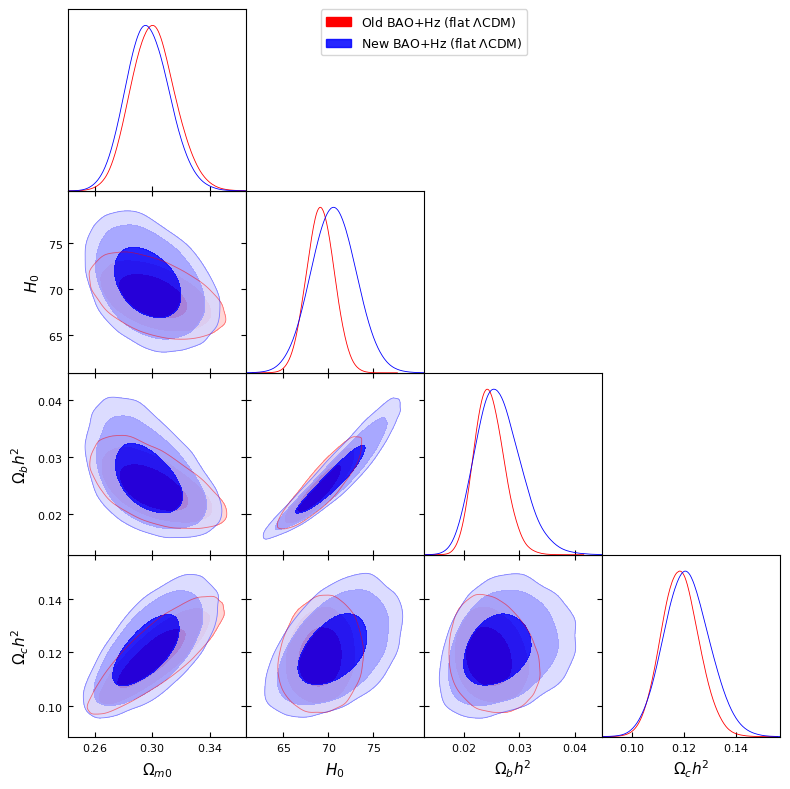

In [16]:
# Prepare OLD chain (Om0, H0)
H0_old = flat_samples_old[:, 0]
Obh2_old = flat_samples_old[:, 1]
Och2_old = flat_samples_old[:, 2]
Ovh2 = 0.06 / 93.14
h_old = H0_old / 100.0
Om0_old = (Obh2_old + Och2_old + Ovh2) / h_old**2
plot_samples_old = np.vstack([Om0_old, H0_old, Obh2_old, Och2_old]).T

# Prepare NEW chain (Om0, H0)
H0_new = flat_samples_new[:, 0]
Obh2_new = flat_samples_new[:, 1]
Och2_new = flat_samples_new[:, 2]
h_new = H0_new / 100.0
Om0_new = (Obh2_new + Och2_new + Ovh2) / h_new**2
plot_samples_new = np.vstack([Om0_new, H0_new, Obh2_new, Och2_new]).T

# Set up GetDist samples
names = ["om0", "H0", "omega_bh2", "omega_ch2"]
labels = [r"\Omega_{m0}", r"H_0", r"\Omega_{b}h^2", r"\Omega_{c}h^2"]
samples_getdist_old = MCSamples(samples=plot_samples_old, names=names, labels=labels)
samples_getdist_new = MCSamples(samples=plot_samples_new, names=names, labels=labels)

# Plot both contours
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 3
g.triangle_plot(
    [samples_getdist_old, samples_getdist_new],
    names=names,
    filled=True,
    legend_labels=['Old BAO+Hz (flat $\Lambda$CDM)', 'New BAO+Hz (flat $\Lambda$CDM)'],
    line_args=[{'color': 'red'}, {'color': 'blue'}],
    contour_colors=['red', 'blue']
)
plt.show()


In [17]:
print("Old Hz+Bao results:")
print(samples_getdist_old.getTable(limit=1).tableTex())
print("New Hz+Bao results:")
print(samples_getdist_new.getTable(limit=1).tableTex())



Old Hz+Bao results:
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_{m0}    $} & $0.301^{+0.014}_{-0.016}   $\\

{\boldmath$H_0            $} & $69.1\pm 1.6               $\\

{\boldmath$\Omega_{b}h^2  $} & $0.0246^{+0.0024}_{-0.0029}$\\

{\boldmath$\Omega_{c}h^2  $} & $0.1184\pm 0.0073          $\\
\hline
\end{tabular}
New Hz+Bao results:
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_{m0}    $} & $0.297^{+0.015}_{-0.016}   $\\

{\boldmath$H_0            $} & $70.6\pm 2.5               $\\

{\boldmath$\Omega_{b}h^2  $} & $0.0263^{+0.0035}_{-0.0045}$\\

{\boldmath$\Omega_{c}h^2  $} & $0.1211^{+0.0082}_{-0.0092}$\\
\hline
\end{tabular}


# Non-Flat $\Lambda$ CDM

In [4]:
def H_theory(z, H0, Obh2, Och2, Ok):
    return H0 * E_nonflat(z, H0, Obh2, Och2, Ok)

In [5]:
def E_nonflat(z, H0, Obh2, Och2, Ok):
    Ovh2 = 0.06 / 93.14  # massive neutrino contribution kept fixed
    h = H0 / 100.0
    Om0 = (Obh2 + Och2 + Ovh2) / h**2
    return np.sqrt(Om0 * (1 + z)**3 + Ok * (1 + z)**2 + (1 - Om0 - Ok))

In [6]:
# Comoving horizon scale Dh(z) = c/H(z)
def Dh_nonflat(z, H0, Obh2, Och2, Ok):
    return c / (H0 * E_nonflat(z, H0, Obh2, Och2, Ok))

# Line-of-sight comoving distance
def Dc_nonflat(z, H0, Obh2, Och2, Ok):
    result, _ = scipy.integrate.quad(lambda zp: 1.0 / E_nonflat(zp, H0, Obh2, Och2, Ok), 0, z)
    return (c / H0) * result

# Transverse comoving distance (includes curvature cases)
def Dm_nonflat(z, H0, Obh2, Och2, Ok):
    dc = Dc_nonflat(z, H0, Obh2, Och2, Ok)
    dh = c / H0
    if abs(Ok) < 1e-8:
        return dc
    elif Ok > 0:
        sqrtk = np.sqrt(Ok)
        return dh / sqrtk * np.sinh(sqrtk * dc / dh)
    else:
        sqrtk = np.sqrt(-Ok)
        return dh / sqrtk * np.sin(sqrtk * dc / dh)

# Angular diameter distance
def Da_nonflat(z, H0, Obh2, Och2, Ok):
    return Dm_nonflat(z, H0, Obh2, Och2, Ok) / (1 + z)

# Volume-averaged distance
def Dv_nonflat(z, H0, Obh2, Och2, Ok):
    return (Dm_nonflat(z, H0, Obh2, Och2, Ok)**2 * z * Dh_nonflat(z, H0, Obh2, Och2, Ok)) ** (1 / 3)

# Sound horizon proxy (same fitting form as earlier cell)
def rs_nonflat(H0, Obh2, Och2, Ok):
    Ovh2 = 0.06 / 93.14
    p1 = np.exp(-72.3 * (Ovh2 + 0.0006)**2)
    p2 = (Obh2)**0.12807 * (Obh2 + Och2)**0.25351
    return 55.154 * p1 / p2


In [7]:
def log_likelihood1_old(theta, z, H_obs, H_err):
    H0, Obh2, Och2,Ok = theta
    H_th = H_theory(z, H0, Obh2, Och2,Ok)
    res = H_obs - H_th
    chi21 = np.sum((res / H_err)**2)
    log_norm = np.sum(np.log(2.0 * np.pi * (H_err**2)))

    return -0.5 * (chi21 + log_norm)

In [8]:
def log_likelihood1_new(theta, z, H_obs, cov_total):
    H0, Obh2, Och2,Ok = theta
    H_th = H_theory(z, H0, Obh2, Och2,Ok)
    res = H_obs - H_th
    inv_cov = np.linalg.inv(cov_total) 
    chi2 = np.dot(res, np.dot(inv_cov, res))
    # Normalization (multivariate normal)
    log_norm = np.linalg.slogdet(2.0 * np.pi * cov_total)[1]
    return -0.5 * (chi2 + log_norm)

In [9]:
c=3e5

In [11]:
def log_likelihood2_old(theta, z_bao, bao_val, cov_matrix):
    H0, Obh2, Och2,Ok = theta
    
    N = len(z_bao)
    D_th = np.zeros(N)
    rs_fid = 147.5

    # Compute sound horizon at each z
    rs_values = rs_nonflat(H0, Obh2, Och2,Ok) * np.ones(N)  # flat model, constant rs for all z

    D_th[0] = Dv_nonflat(z_bao[0], H0, Obh2, Och2,Ok) * rs_fid / rs_values[0]      # Dv/rs @ z=0.122
    D_th[7] = Da_nonflat(z_bao[7], H0, Obh2, Och2,Ok) / rs_values[7]               # Da/rs @ z=0.81
    for i in [1,3,5,8,10]:       # Dm/rs indices
        D_th[i] = Dm_nonflat(z_bao[i], H0, Obh2, Och2,Ok) / rs_values[i]
    for i in [2,4,6,9,11]:       # Dh/rs indices
        D_th[i] = Dh_nonflat(z_bao[i], H0, Obh2, Och2,Ok) / rs_values[i]

    res = bao_val - D_th

    inv_cov = np.linalg.inv(cov_matrix)
    chi2 = np.dot(res, np.dot(inv_cov, res))
    log_norm = np.linalg.slogdet(2.0 * np.pi * cov_matrix)[1]

    return -0.5 * (chi2 + log_norm)


In [12]:
def log_likelihood2_new(theta, z_bao, bao_val, cov_matrix):
    H0, Obh2, Och2,Ok = theta
    
    N = len(z_bao)
    D_th = np.zeros(N)
    rs_fid = 147.5

    # Compute sound horizon at each z
    rs_values = rs_nonflat(H0, Obh2, Och2,Ok) * np.ones(N)  # flat model, constant rs for all z

    D_th[0] = Dv_nonflat(z_bao[0], H0, Obh2, Och2,Ok) * rs_fid / rs_values[0]      # Dv/rs @ z=0.122
    #D_th[7] = Da_nonflat(z_bao[7], H0, Obh2, Och2,Ok) / rs_values[7]               # Da/rs @ z=0.81
    for i in [1,3,5,7,8,10]:       # Dm/rs indices
        D_th[i] = Dm_nonflat(z_bao[i], H0, Obh2, Och2,Ok) / rs_values[i]
    for i in [2,4,6,9,11]:       # Dh/rs indices
        D_th[i] = Dh_nonflat(z_bao[i], H0, Obh2, Och2,Ok) / rs_values[i]

    res = bao_val - D_th

    inv_cov = np.linalg.inv(cov_matrix)
    chi2 = np.dot(res, np.dot(inv_cov, res))
    log_norm = np.linalg.slogdet(2.0 * np.pi * cov_matrix)[1]

    return -0.5 * (chi2 + log_norm)


In [13]:
def log_prior(theta):
    H0, Obh2, Och2,Ok = theta
    if 0.0 < Obh2 < 1.0 and 0.0 < Och2 < 1.0 and -2.0< Ok<2.0:
        return 0.0
    return -np.inf

In [14]:
def log_probability_new(theta, z, H_obs, cov_total,z_bao, bao_val, cov_matrix):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood1_new(theta, z, H_obs, cov_total)+log_likelihood2_new(theta, z_bao, bao_val, cov_matrix)


In [15]:
def log_probability_old(theta, z, H_obs, H_err,z_bao, bao_val, cov_matrix):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood1_old(theta, z, H_obs, H_err)+log_likelihood2_old(theta, z_bao, bao_val, cov_matrix)


In [16]:
print("Old Hz+Bao")
def negative_log_probability_old(theta, z, H_obs, H_err,z_bao, bao_val, cov_matrix):
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return 1e10
    return -log_likelihood1_old(theta, z, H_obs, H_err) - log_likelihood2_old(theta, z_bao, bao_val, cov_matrix)

theta_init = [70.0, 0.5, 0.5,0]

result = minimize(
    negative_log_probability_old,
    theta_init,
    args=(z_data_old, Hz_data_old, sigma_data_old, z_oldbao, oldbao_val, cov_matrix_old),
    method='Nelder-Mead'
)

best_fit_params_old = result.x
print("Best-fit parameters (rounded): H0 = {:.3f}, Obh2 = {:.3f}, Och2 = {:.3f}, Ok0 = {:.3f}".format(*best_fit_params_old))
print("Minimized negative log likelihood:", result.fun)
print("New Hz+Bao")
def negative_log_probability_new(theta, z, H_obs, cov_total,z_bao, bao_val, cov_matrix):
    logp = log_prior(theta)
    if not np.isfinite(logp):
        return 1e10
    return -log_likelihood1_new(theta, z, H_obs, cov_total) - log_likelihood2_new(theta, z_bao, bao_val, cov_matrix)

theta_init = [70,0.5,0.5,0]

result = minimize(
    negative_log_probability_new,
    theta_init,
    args=(z_data_new, Hz_data_new, cov_total, z_newbao, newbao_val, cov_matrix_new),
    method='Nelder-Mead'
)

best_fit_params_new = result.x
print("Best-fit parameters (rounded): H0 = {:.3f}, Obh2 = {:.3f}, Och2 = {:.3f}, Ok0 = {:.3f}".format(*best_fit_params_new))
print("Minimized negative log likelihood:", result.fun)



Old Hz+Bao
Best-fit parameters (rounded): H0 = 68.329, Obh2 = 0.026, Och2 = 0.110, Ok0 = 0.048
Minimized negative log likelihood: 135.310308347226
New Hz+Bao
Best-fit parameters (rounded): H0 = 69.635, Obh2 = 0.027, Och2 = 0.113, Ok0 = 0.038
Minimized negative log likelihood: 141.24436483296634


In [18]:
print("Old Hz+Bao")
pos = best_fit_params_old + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_old, args=(z_data_old, Hz_data_old,sigma_data_old, z_oldbao, oldbao_val, cov_matrix_old)
)
sampler.run_mcmc(pos, 5000, progress=True)

tau = sampler.get_autocorr_time()
print("Autocorrelation time:", tau)

burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples_old = sampler.get_chain(discard=burnin, thin=thin, flat=True)

labels = ["H0", "omega_bh2", "omega_ch2", "omegak0"]
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples_old.shape))


Old Hz+Bao


100%|██████████| 5000/5000 [18:52<00:00,  4.41it/s]


Autocorrelation time: [44.51756239 50.54858897 48.34948067 47.41968445]
burn-in: 101
thin: 22
flat chain shape: (44400, 4)


In [19]:
print("New Hz+Bao")
pos = best_fit_params_new + 1e-4 * np.random.randn(200, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_new, args=(z_data_new, Hz_data_new, cov_total, z_newbao, newbao_val, cov_matrix_new)
)
sampler.run_mcmc(pos, 5000, progress=True)

tau = sampler.get_autocorr_time()
print("Autocorrelation time:", tau)

burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples_new = sampler.get_chain(discard=burnin, thin=thin, flat=True)

labels = ["H0", "omega_bh2", "omega_ch2", "omegak0"]
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples_new.shape))

New Hz+Bao


100%|██████████| 5000/5000 [28:11<00:00,  2.96it/s]


Autocorrelation time: [46.51073928 53.12690053 49.39415343 50.01960207]
burn-in: 106
thin: 23
flat chain shape: (42400, 4)


<>:32: SyntaxWarning: invalid escape sequence '\L'
<>:32: SyntaxWarning: invalid escape sequence '\L'
<>:32: SyntaxWarning: invalid escape sequence '\L'
<>:32: SyntaxWarning: invalid escape sequence '\L'
C:\Users\sumit\AppData\Local\Temp\ipykernel_16188\2940045691.py:32: SyntaxWarning: invalid escape sequence '\L'
  legend_labels=['Old BAO+Hz (non-flat $\Lambda$CDM)', 'New BAO+Hz (non-flat $\Lambda$CDM)'],
C:\Users\sumit\AppData\Local\Temp\ipykernel_16188\2940045691.py:32: SyntaxWarning: invalid escape sequence '\L'
  legend_labels=['Old BAO+Hz (non-flat $\Lambda$CDM)', 'New BAO+Hz (non-flat $\Lambda$CDM)'],


Removed no burn in
Removed no burn in


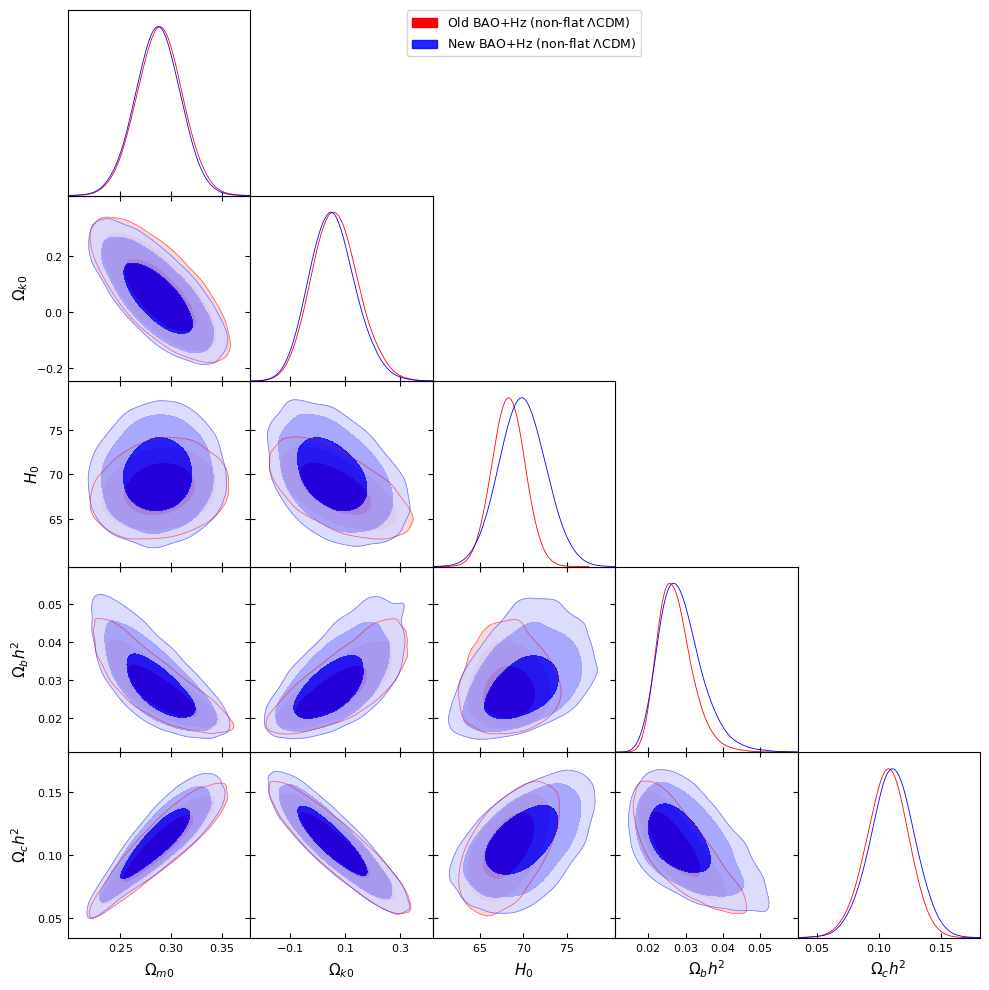

In [20]:
H0_old = flat_samples_old[:,0]
Obh2_old = flat_samples_old[:,1]
Och2_old = flat_samples_old[:,2]
Ok_old = flat_samples_old[:,3]
Ovh2_old = 0.06/93.14
h_old = H0_old / 100.0
Omegam0 = (Obh2_old + Och2_old + Ovh2_old) / h_old**2
Omegak0 = Ok_old
plot_samples_old = np.column_stack([Omegam0, Omegak0, H0_old, Obh2_old, Och2_old])

H0_new = flat_samples_new[:,0]
Obh2_new = flat_samples_new[:,1]
Och2_new = flat_samples_new[:,2]
Ok_new = flat_samples_new[:,3]
Ovh2_new = 0.06/93.14
h_new = H0_new / 100.0
Omegam0 = (Obh2_new + Och2_new + Ovh2_new) / h_new**2
Omegak0 = Ok_new
plot_samples_new = np.column_stack([Omegam0, Omegak0, H0_new, Obh2_new, Och2_new])


labels = [r"\Omega_{m0}", r"\Omega_{k0}", r"H_0", r"\Omega_{b}h^2", r"\Omega_{c}h^2"]
names = ["Omegam0", "Omegak0", "H0", "omega_bh2", "omega_ch2"]

samples_getdist_old = MCSamples(samples=plot_samples_old, names=names, labels=labels)
samples_getdist_new = MCSamples(samples=plot_samples_new, names=names, labels=labels)
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 3
g.triangle_plot(
    [samples_getdist_old, samples_getdist_new],
    filled=True,
    legend_labels=['Old BAO+Hz (non-flat $\Lambda$CDM)', 'New BAO+Hz (non-flat $\Lambda$CDM)'],
    line_args=[{'color': 'red'}, {'color': 'blue'}],
    contour_colors=['red', 'blue']
)
plt.show()

In [21]:
print("Old Hz+Bao results:")
print(samples_getdist_old.getTable(limit=1).tableTex())
print("New Hz+Bao results:")
print(samples_getdist_new.getTable(limit=1).tableTex())



Old Hz+Bao results:
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_{m0}    $} & $0.289\pm 0.023            $\\

{\boldmath$\Omega_{k0}    $} & $0.064^{+0.079}_{-0.091}   $\\

{\boldmath$H_0            $} & $68.3\pm 1.9               $\\

{\boldmath$\Omega_{b}h^2  $} & $0.0274^{+0.0034}_{-0.0054}$\\

{\boldmath$\Omega_{c}h^2  $} & $0.107\pm 0.017            $\\
\hline
\end{tabular}
New Hz+Bao results:
\begin{tabular} { l  c}

 Parameter &  68\% limits\\
\hline
{\boldmath$\Omega_{m0}    $} & $0.287\pm 0.022            $\\

{\boldmath$\Omega_{k0}    $} & $0.054^{+0.077}_{-0.090}   $\\

{\boldmath$H_0            $} & $69.9\pm 2.7               $\\

{\boldmath$\Omega_{b}h^2  $} & $0.0288^{+0.0042}_{-0.0067}$\\

{\boldmath$\Omega_{c}h^2  $} & $0.111\pm 0.018            $\\
\hline
\end{tabular}
